[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

It includes the following datasets

* train.csv
* test.csv
* sample_submission.csv
* stores.csv
* oil.csv
* holiday_events.csv

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

**Features**

Kaggle explains the features of all the provided datasets in the [competition data tab](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)



## Download Kaggle Data

Uncomment the below codeblock to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [1]:
# from google.colab import userdata
# import os

# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# !kaggle competitions download -c store-sales-time-series-forecasting

# ! unzip "store-sales-time-series-forecasting.zip" -d data

# Part 1: Exploratory Data Analysis (EDA)

In [1]:
# ensure required libraries are installed
!pip -q install sktime pmdarima seaborn

# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Dataset Vocab 

* *date*: Date of entry
* *store_nbr*: Store Number
* *family*: Product Family
* *onpromotion*: Items in a product family being promoted at a store at a given date.
* *sales (Target variable)*: Total sales for a product family at a particular store at a given date.
* *cluster*: Grouping of similar stores
* *type*: Type of Store
* *city*: City
* *state*: State the store is located in
* *holiday_type & locale* : If it was a holiday and type of holiday
* *transactions*: Number of transactions

## Datasets

The datasets provided by Kaggle include: 

**train.csv**
* The training data, comprising time series of features 
- store_nbr
- family
- onpromotion
- sales (target)

**test.csv**
The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

**sample_submission.csv**
A sample submission file in the correct format.

**stores.csv**
Store metadata, including 
- city, 
- state, 
- type, and 
- cluster.

**oil.csv**
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

**holidays_events.csv**
Holidays and Events, with metadata

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

**Additional Notes**
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [61]:
# Load the datasets
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',

    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

store_metadata = pd.read_csv(
    './data/stores.csv',
    dtype=dtype,
)

daily_oil_price = pd.read_csv(
    './data/oil.csv',
    dtype=dtype,
    parse_dates=['date']
)

holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype=dtype,
    parse_dates=['date']
)

transactions = pd.read_csv(
    './data/transactions.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [62]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    category      
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(2), datetime64[ns](1), float32(1), int64(1), uint64(1)
memory usage: 85.9 MB


In [63]:
store_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     category
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(5)
memory usage: 5.1 KB


In [64]:
daily_oil_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 14.4 KB


In [65]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    category      
 2   locale       350 non-null    category      
 3   locale_name  350 non-null    category      
 4   description  350 non-null    string        
 5   transferred  350 non-null    bool          
dtypes: bool(1), category(3), datetime64[ns](1), string(1)
memory usage: 8.0 KB


In [66]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  category      
 2   transactions  83488 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.4 MB


## Columns
* date: Date of entry
* store_nbr: Store Number
* sales: the turnover for any given day (target variable).
* family: Product Family
* store_type: Type of Store
* cluster: Store Cluster
* city: City
* state: State the store is located in
* onpromotion: indicates whether a store is running a promo on that day.
* holiday_type & locale : If it was a holiday and type of holiday
* transactions: Number of transactions
* sales: sales volume

## Data Visualization

# TREND

Let's Examine the Trend in Favorita store sales by answering the following questions.

1. Total store sales strend
2. Product families' sales trend
3. Total transactions trend

In [133]:
# Function for moving average plot
def plot_moving_average(df, plot_df=None, title="N/A", windows=None, axes=None, remove_legend=False, legend_loc=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(30,18))

    if windows is None:
      windows = [7, 30, 92, 365]
    
    if axes is None:
      axes =[ax1, ax2, ax3, ax4]

    if plot_df is None:
          plot_df = df

    for window, ax in zip(windows, axes):
      moving_average = df.rolling(
          window=window,
          center=True,
          min_periods=window//2
      ).mean()

      plot_df.plot(style=".", color="0.5", ax=ax)
      moving_average.plot(
          ax=ax, linewidth=3, title=f"{title} {window}-Day Moving Average", legend=False
      )

      if remove_legend:
        try:
          ax.get_legend().remove()
        except:
          pass

    # Use a single Legend
    if legend_loc:
      handles, labels = axes[-1].get_legend_handles_labels()
      fig.legend(handles, labels, loc=legend_loc);

In [134]:
# 1. Average sales Favorita makes each day
daily_average_sales = store_sales.groupby('date')['sales'].mean()
daily_average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Name: sales, Length: 1684, dtype: float32

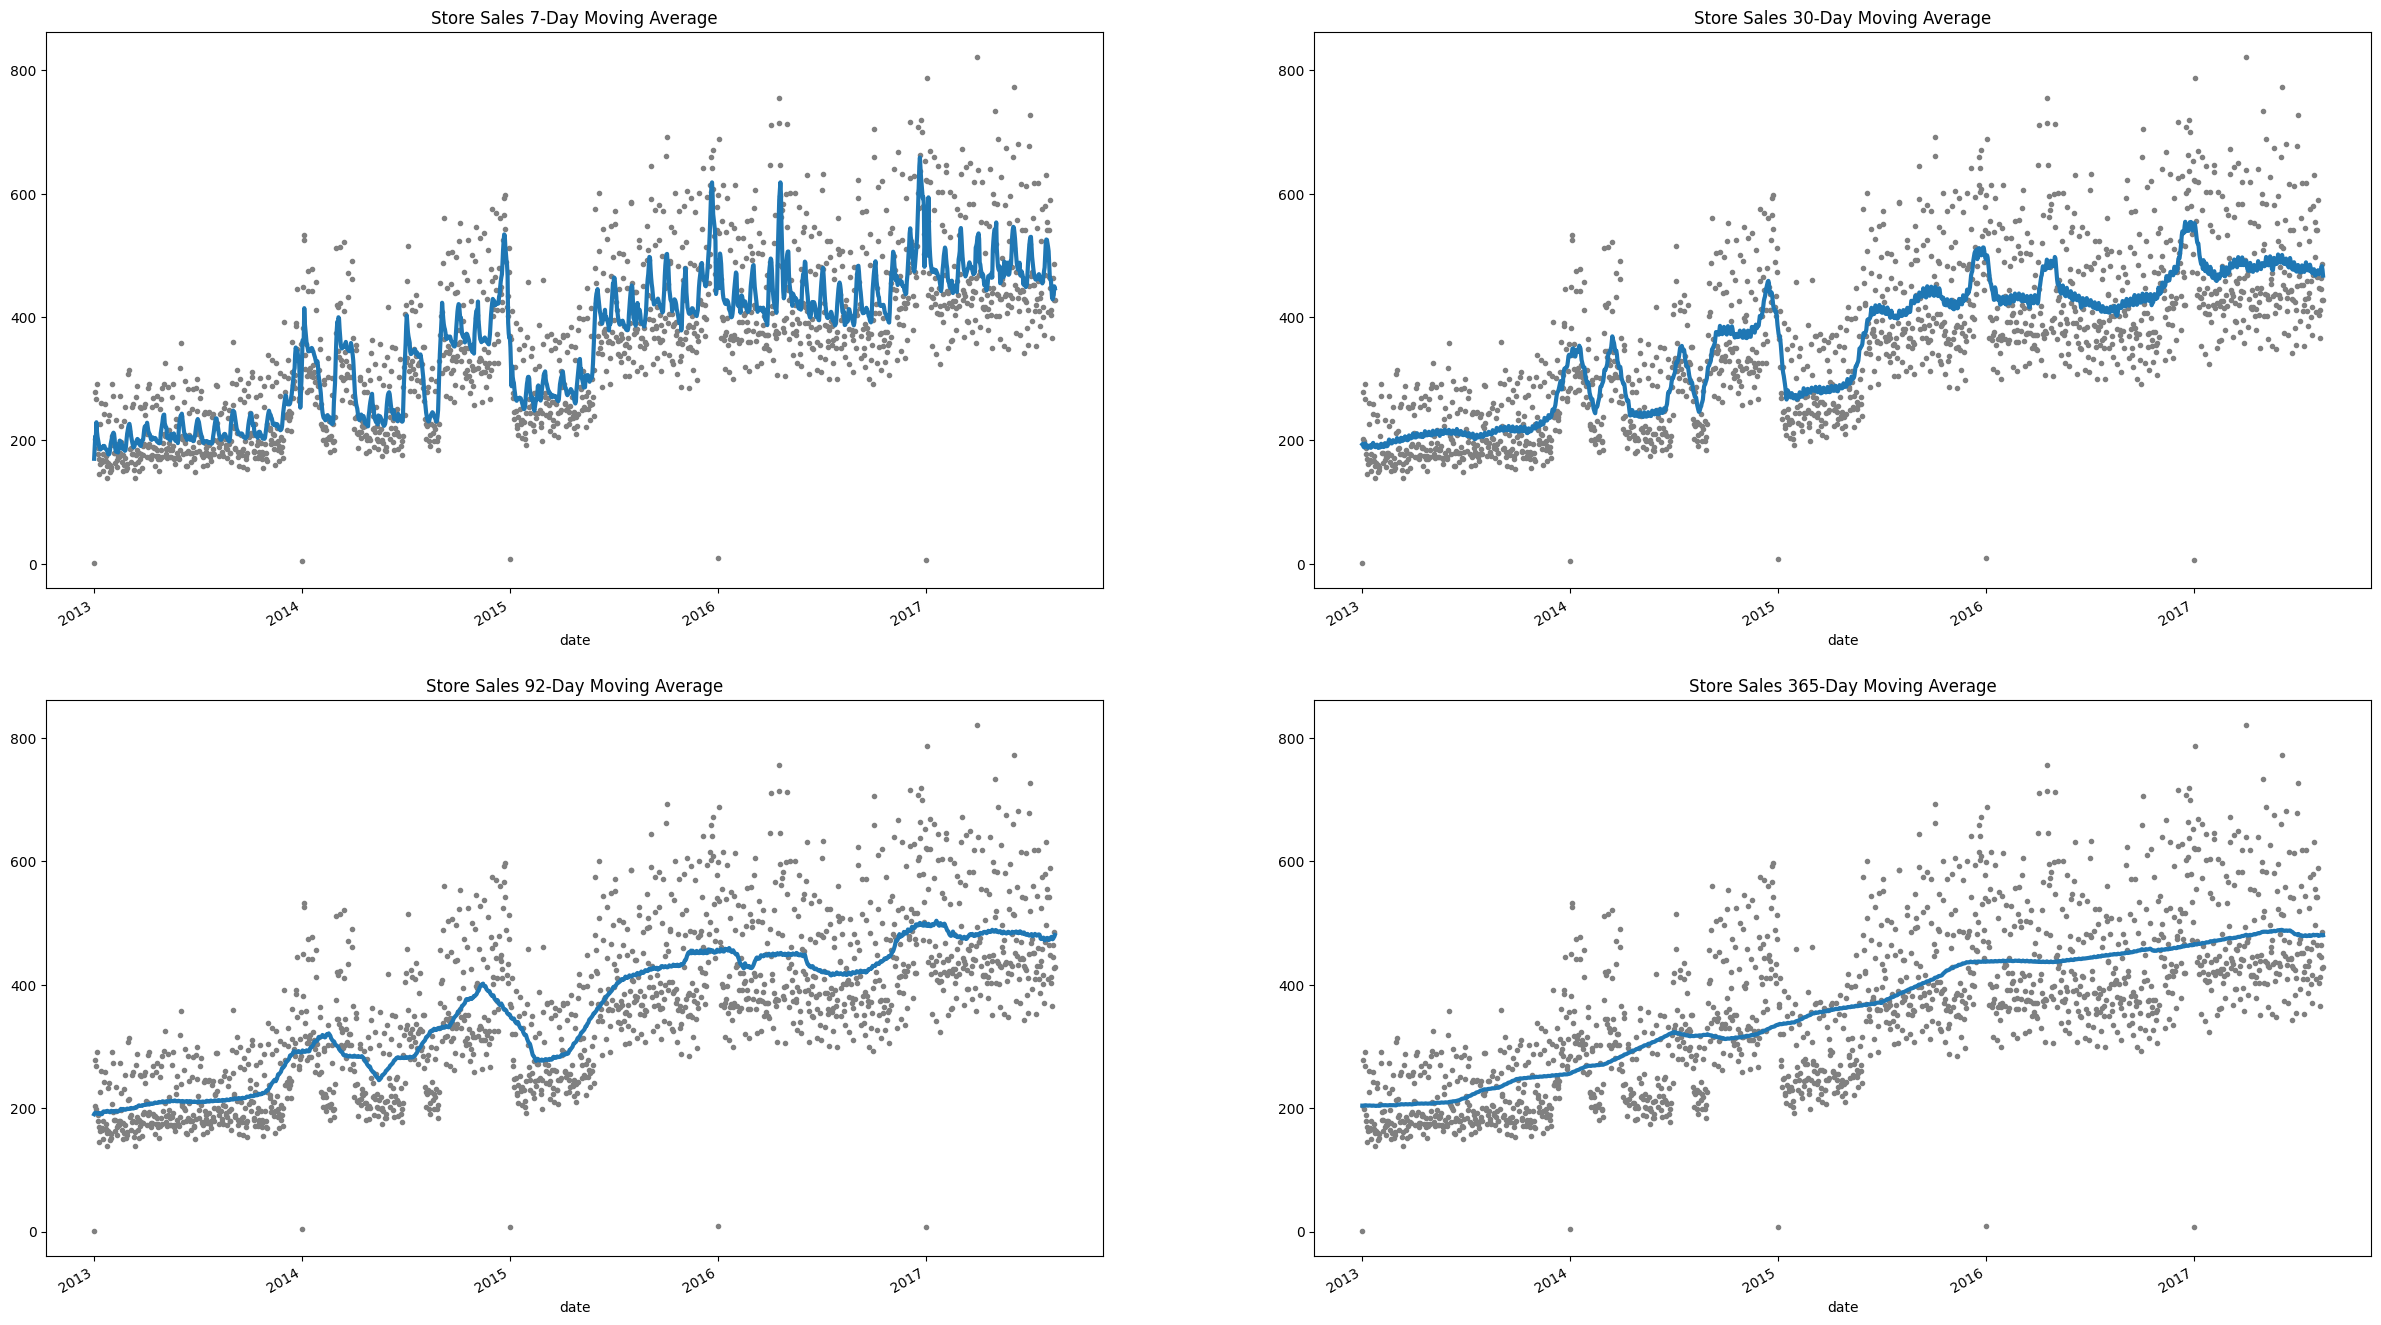

In [135]:
# Let's see the trend
plot_moving_average(df=daily_average_sales, title="Store Sales")

##2. Average sales each product family brings to Favorita each day


Favorita stores has 33 product families.
* What's the sales trend for each product family?

In [136]:
# Group by 'date' and 'family', calculate mean sales
daily_avg_family_sales = store_sales.groupby(['date', 'family'])['sales'].mean().reset_index()

# Pivot the data for easier plotting (date as index, family as columns)
pivot_df = daily_avg_family_sales.pivot(index='date', columns='family', values='sales')
pivot_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853935,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897324,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946684
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350845,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067350


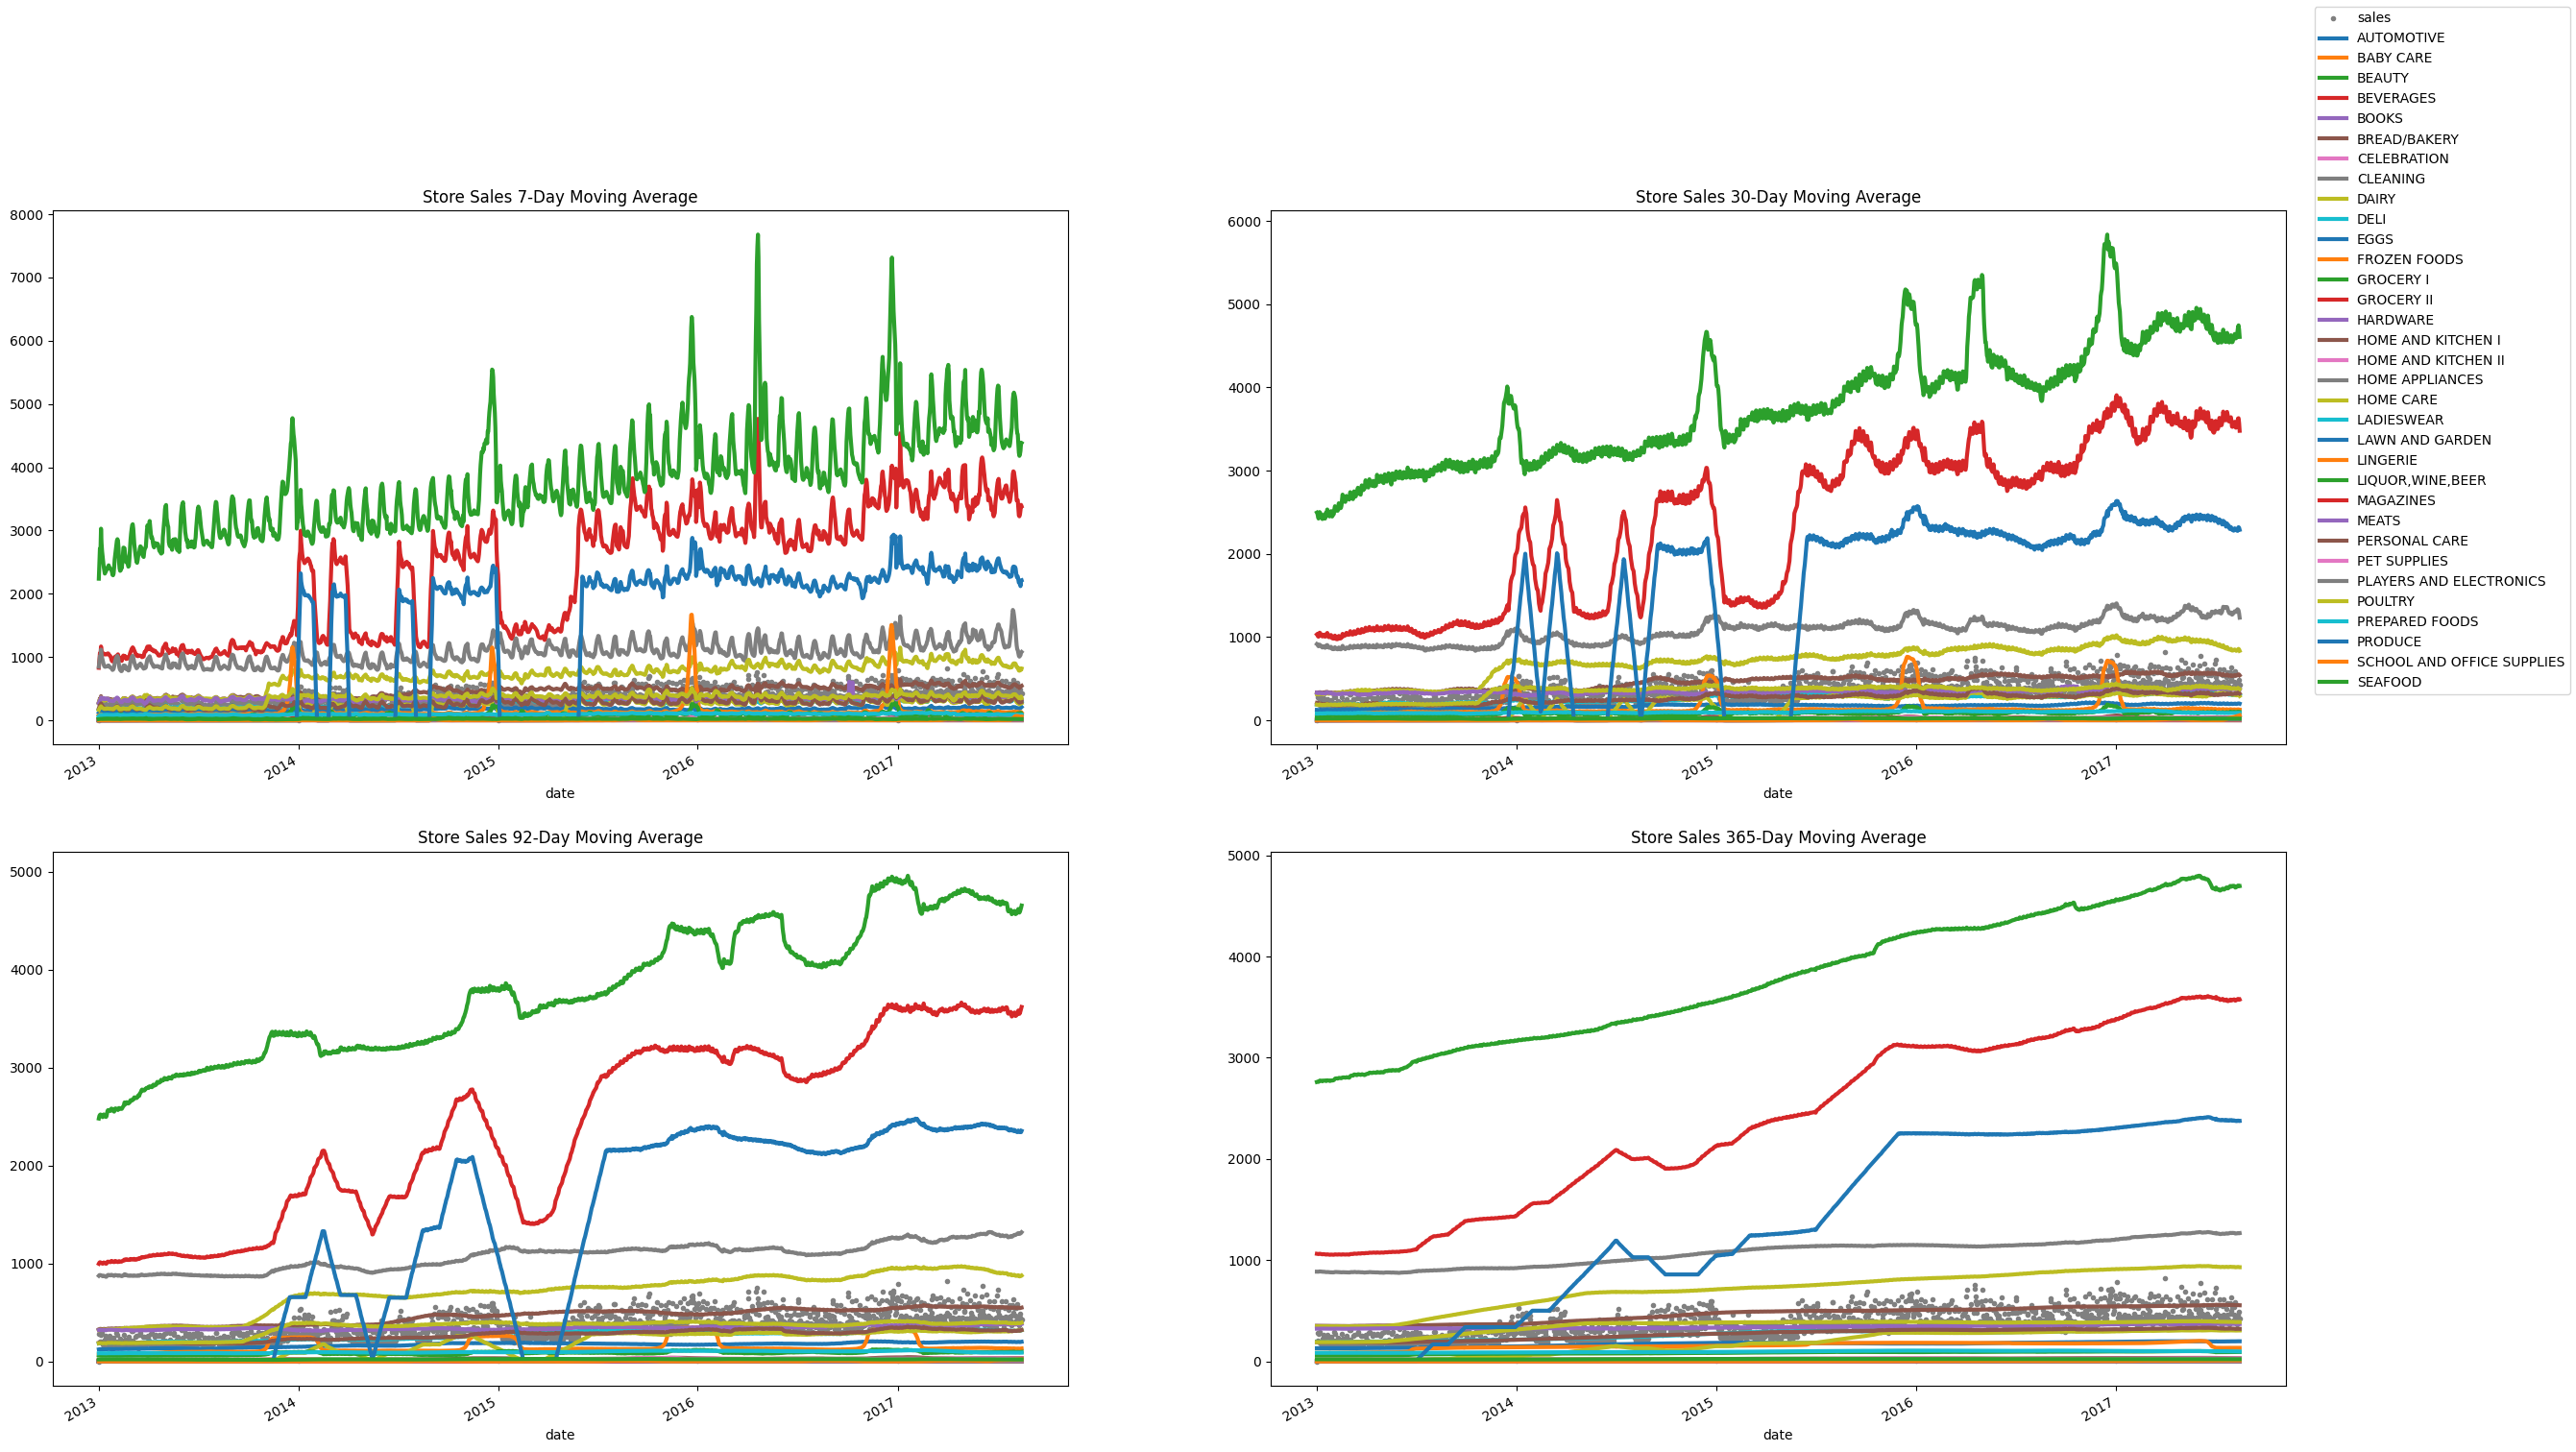

In [137]:
plot_moving_average(df=pivot_df, plot_df=daily_average_sales, title="Store Sales", legend_loc="upper right")

In [138]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


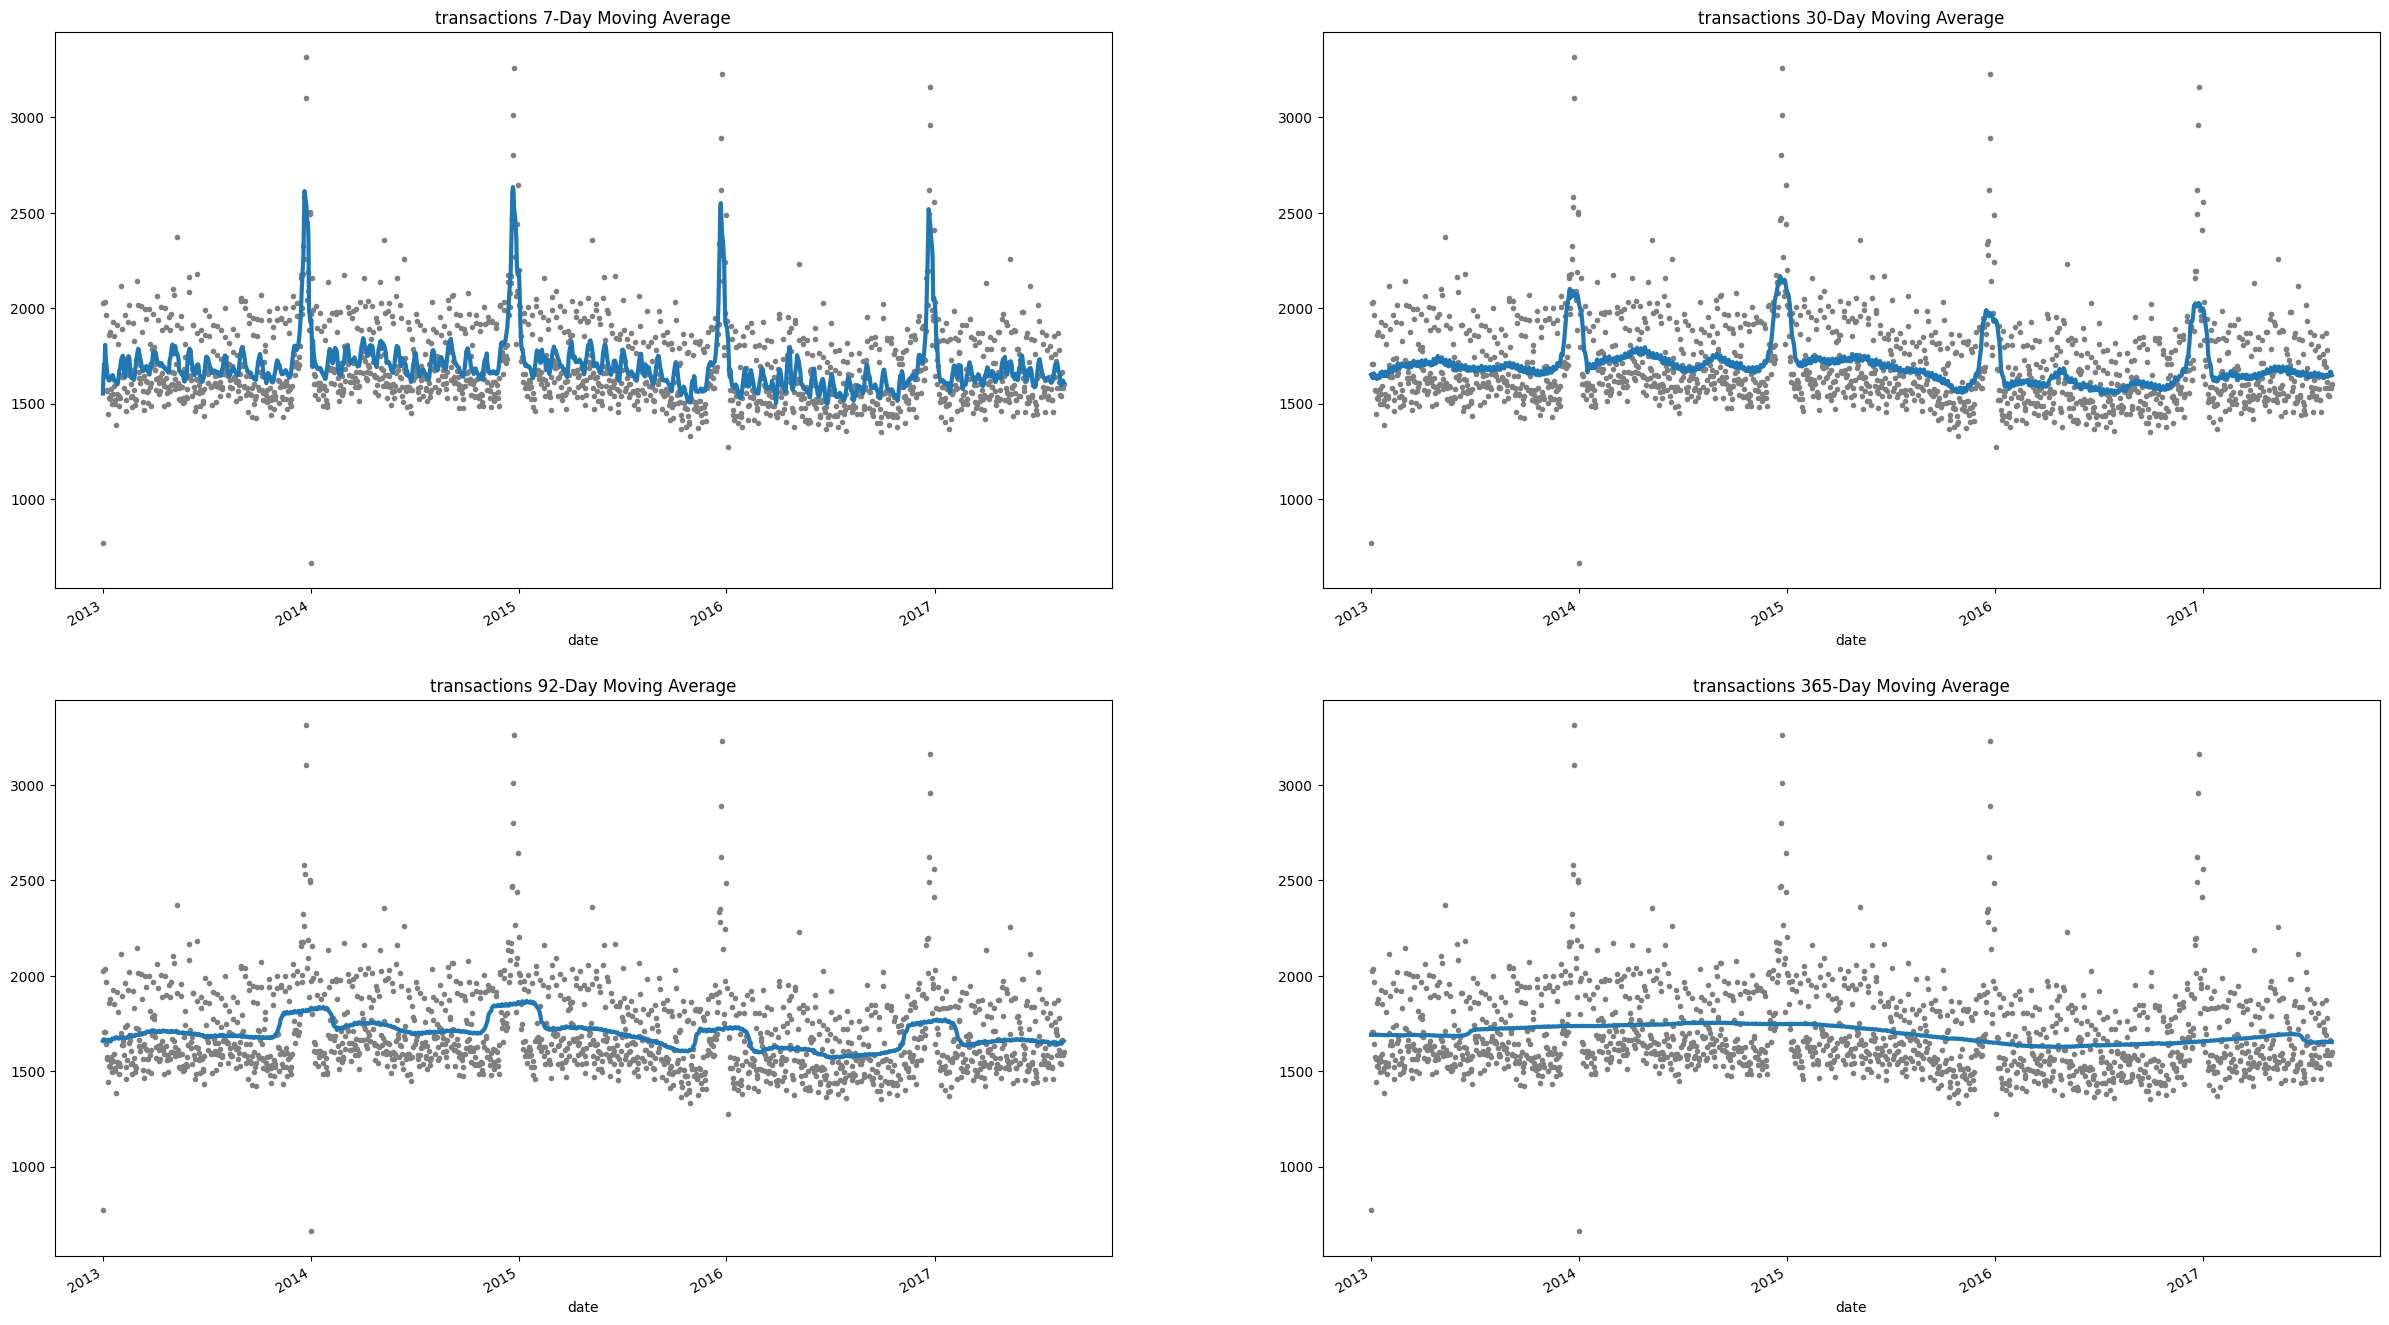

In [139]:
plot_moving_average(
    df=transactions.groupby('date')['transactions'].mean(),
    title="transactions",
    )

### Product families with highest sales values.

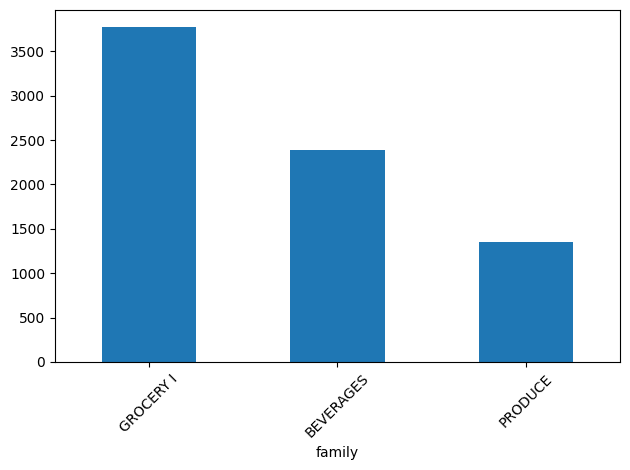

In [140]:
# Group by product 'family' and calculate the average sales
avg_sales = store_sales.groupby('family')['sales'].mean().sort_values(ascending=False)

# Take the top n product families
n = 3
top_families = avg_sales.head(n)

#  Plottinh
top_families.plot(kind="bar")
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures all labels fit within the figure area
plt.show()

View the Top families sales trend

In [141]:
pivot_df_filtered = pivot_df[top_families.index]

# Calculate daily average sales for the top families
daily_avg_sales_top_families = pivot_df_filtered.mean(axis=1)
daily_avg_sales_top_families

date
2013-01-01       9.320988
2013-01-02    1692.049316
2013-01-03    1215.944458
2013-01-04    1172.351807
2013-01-05    1643.049316
                 ...     
2017-08-11    3370.809326
2017-08-12    3288.481445
2017-08-13    3621.729736
2017-08-14    3181.760986
2017-08-15    3210.432617
Length: 1684, dtype: float32

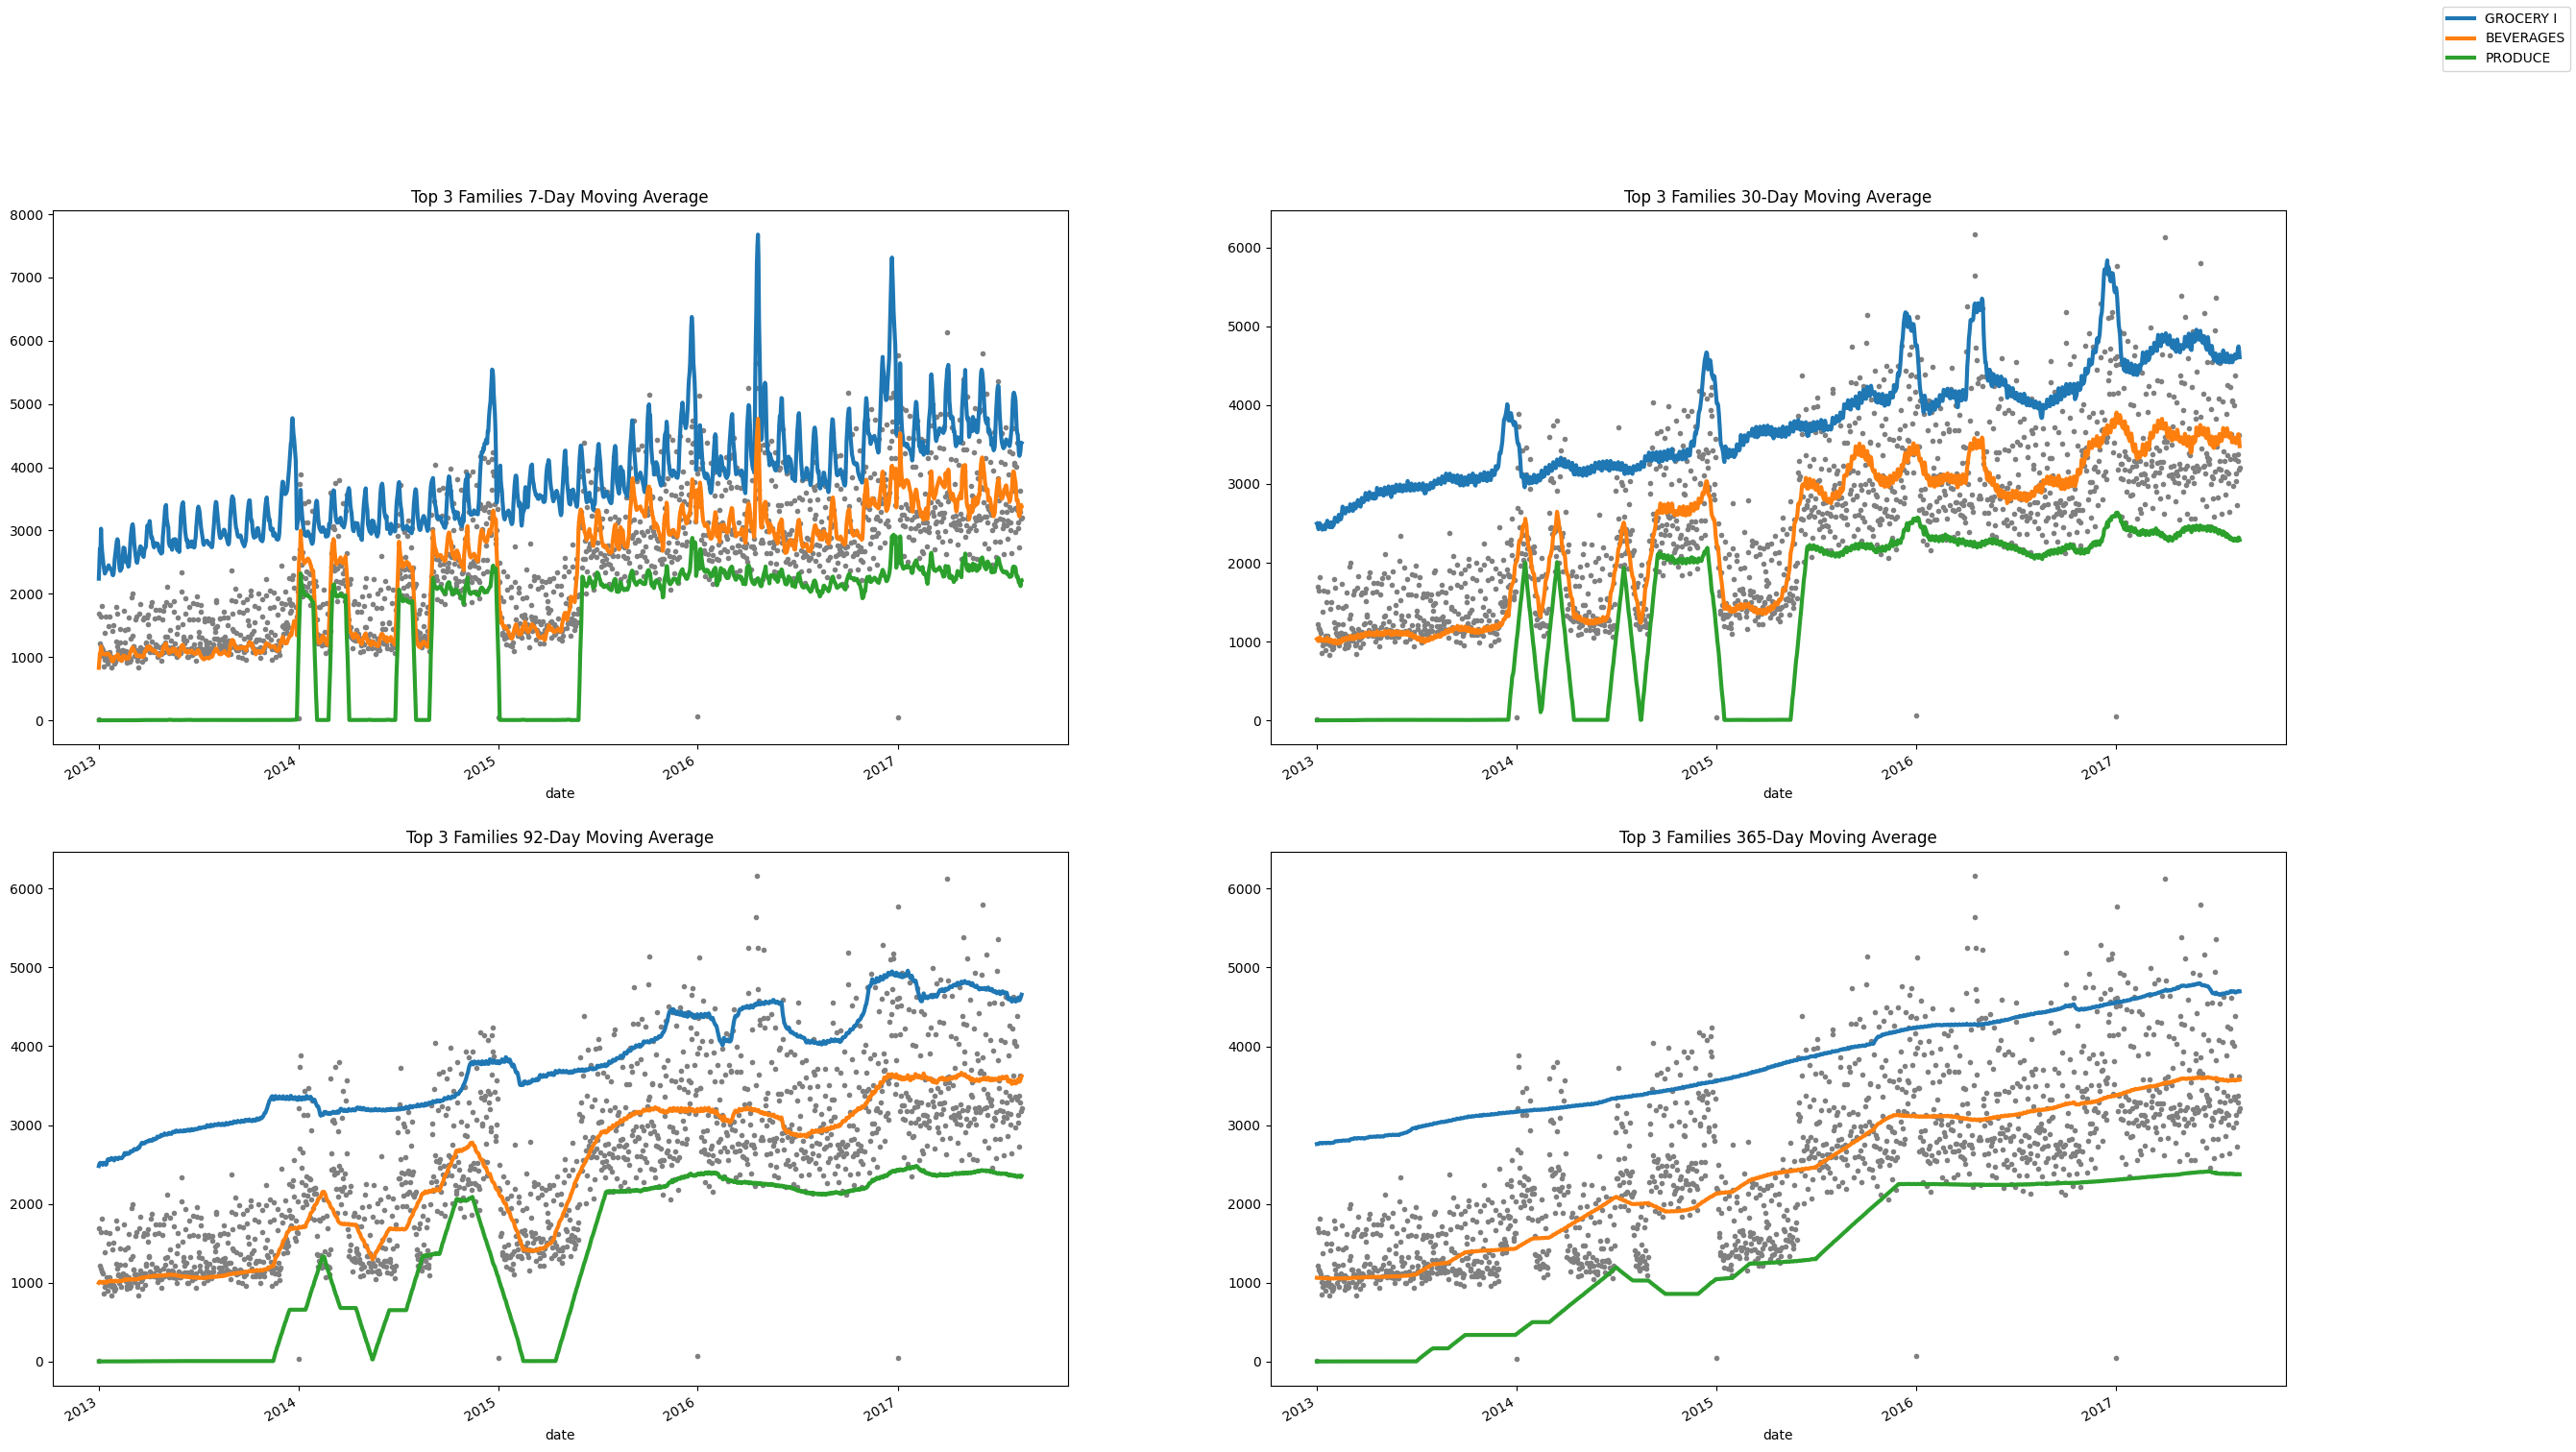

In [142]:
plot_moving_average(
    pivot_df_filtered, 
    title=f"Top {n} Families",
    plot_df= daily_avg_sales_top_families, legend_loc="upper right")

how many stores? how many product groups?
coverage in terms of start/end of record per store
summary of sales by store, do statistical summaries on the summaries. E.g., average sales in a year, variation, etc.
there are marked "jumps" in the mean aggregate over stores. What explains these? Could be artefact start/end
similar analysis for product groups
interaction analysis product groups and stores. Which stores sell which products? How does the product compositiòn distribute?